In [1]:
import sys
sys.path.insert(0,"/home/jperrie/Documents/PySpots")
from MERFISH_Objects.FISHData import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from sklearn.preprocessing import normalize
from scipy.optimize import minimize_scalar

from dredFISH.Analysis import TissueGraph as tg
from dredFISH.Visualization.utils import  get_aggregate_counts, avg_dend, cut_dend
from dredFISH.Visualization.cell_colors import colors_from_list
from dredFISH.Visualization.vor import bounding_box_grid

from copy import copy
from collections import Counter
import scanpy as sc

%load_ext line_profiler

In [2]:
# make sure to start the ipcluster: !ipcluster start -n 16 (or as many cores as you want)
from ipyparallel import Client
rc = Client()

In [3]:
base_path = '/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/'
dataset = 'DPNMF_PolyA_2021Nov19'
fishdata = FISHData(os.path.join(base_path,'fishdata'))
data = fishdata.load_data('h5ad',dataset=dataset)
data.obs_names_make_unique()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [4]:
data.X = data.layers['total_vectors']
data = data[np.isnan(data.X.max(1))==False]

data.X = data.X/data.obs['total_signal'][:,None]
data.X = data.X - np.array([np.percentile(data.X[:,i],25) for i in range(data.X.shape[1])])
data.X = data.X / np.array([np.percentile(data.X[:,i],75) for i in range(data.X.shape[1])])
data.X = normalize(data.X)

XY = np.asarray([data.obs['stage_y'], data.obs['stage_x']])
XY = np.transpose(XY)
data.obsm['stage'] = XY

<ipython-input-4-15fa24e82a03>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data.X = data.X/data.obs['total_signal'][:,None]


In [5]:
TG = tg.TissueGraph()
TG.BuildSpatialGraph(XY)

In [6]:
sc.pp.neighbors(data, n_neighbors=10, n_pcs=0)
dview = rc[:]
@dview.parallel(block = True)
def Leiden(res):
    scanpy.tl.leiden(data,resolution=res)
    cls = data.obs['leiden']
    return(cls)

with dview.sync_imports():  
    import scanpy

datadict = {"data" : data}
dview.push(datadict)

ResVec = np.logspace(-1,1.5,16)
entropy = np.empty(len(ResVec))
permentropy =  np.empty(len(ResVec))
Sz = np.empty(len(ResVec))
results = Leiden(ResVec)

Nzones = np.empty(len(ResVec))
permNzones = np.zeros(len(ResVec))

TG.Type=np.asarray(results[-1])

for j in range(len(results)):
    cls = np.asarray(results[j])
    Sz[j] = np.max(cls.astype(np.uint16)) 
    TypeVec = np.asarray(results[j])
    ZG = TG.ContractGraph(TypeVec)
    Nzones[j]=ZG.G.vcount()
    entropy[j] = ZG.CondEntropy()
    permZG = TG.ContractGraph(np.random.permutation(TypeVec))
    permNzones[j] = permZG.G.vcount()
    permentropy[j] = permZG.CondEntropy()

importing scanpy on engine(s)


In [7]:
def OptLeiden(res):
    sc.tl.leiden(data,resolution=res)
    TypeVec = np.asarray(data.obs['leiden'])
    ZG = TG.ContractGraph(TypeVec)
    entropy = ZG.CondEntropy()
    return(-entropy)

res = minimize_scalar(OptLeiden, bracket = (0.1,30), method='brent',options={'xtol': 1e-2, 'disp': True})
res['fun']
res['x']

<ipython-input-7-af72936d3477>:8: OptimizeWarning: Unknown solver options: disp
  res = minimize_scalar(OptLeiden, bracket = (0.1,30), method='brent',options={'xtol': 1e-2, 'disp': True})


0.12355617939390529

In [8]:
#typ = np.asarray(results[np.argmax(entropy)])
typ=np.asarray(results[8])
df=pd.DataFrame(data.X)
df.index=typ

In [10]:
%%time
if df.shape[0]<20:
    color_dict = colors_from_list(df.index, copy(df), pca_dim=mat.shape[0], lum=50)
else:
    color_dict = colors_from_list(df.index, copy(df), lum=50)

CPU times: user 17min 13s, sys: 2.25 s, total: 17min 16s
Wall time: 18 s


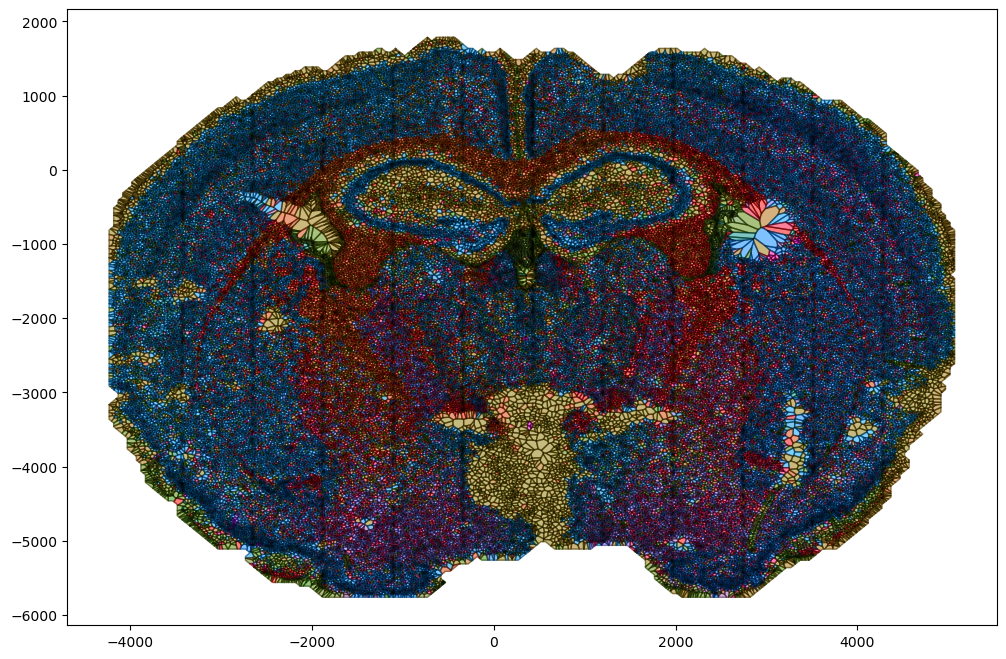

CPU times: user 5min 54s, sys: 10.2 s, total: 6min 4s
Wall time: 5min 58s


In [11]:
%%time
TG.plot(cell_type=typ, color_dict=color_dict, graph_params={"border_alpha":0.3})
plt.show()